---
title: "Creating AI Music Videos with Stable Diffusion"
description: "A tutorial on how to create AI music videos using the text-to-image model Stable Diffusion."
author: "Nate Raw"
date: "2022-10-11"
categories: [code, guide, stable-diffusion]
image: ../static/sd_music_videos/thumbnail.jpg
insert_colab_badge: true
---

In [10]:
%%capture
! pip install diffusers==0.4.0 transformers

Today, we'll talk about how we can leverage Stable Diffusion to generate captivating music videos that move to the beat of a song.

The point of this notebook is to learn how this process works.

***If you don't care about the details, you can just go check out the [Stable Diffusion Videos repo](https://github.com/nateraw/stable-diffusion-videos) instead, where all this work is nicely wrapped up for you already.***


If you like this notebook:

  - consider giving this [repo a star](https://github.com/nateraw/stable-diffusion-videos) ⭐️
  - consider following me on Github [@nateraw](https://github.com/nateraw)

### Examples

Here are some examples of videos you'll be able to generate using the techniques we describe below:

  - [Example 1](https://twitter.com/_nateraw/status/1578049976206237705)
  - [Example 2](https://twitter.com/_nateraw/status/1578056368078086144)
  - [Example 3](https://twitter.com/_nateraw/status/1580322593240133632)

### Background

You probably remember seeing videos like this, where folks were interpolating the latent space of StyleGAN models:

![StyleGAN3 gif](https://huggingface.co/datasets/nateraw/documentation-images/resolve/main/stylegan3_interpolation_sm.gif)

These were soooo mindblowing at one time 🤯. But, they were limited in that you would have to train a separate model for each concept you wanted to generate images for. Even when class conditioned versions came out, they were still limited by the classes the model knew.

Our goal is to generate videos like the above, but with Stable Diffusion. This should let us interpolate between images of anything we want!

### Stable Diffusion Inference ELI5

At the most basic level, all you need to know is that the model we'll be working with takes in 2 inputs:

1. A random noise vector (containing samples drawn from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution))
2. A text prompt that will be used to condition the image generation diffusion process

All else remaining constant, if you pass the *same* noise vector to the model more than once, it will generate the **exact same image**.

However, **if you change that noise vector** a different collection of samples drawn from a normal distribution, **you'll get a different image**.

For a more in depth explanation of how diffusion models work, check out this [legendary writeup on the Hugging Face blog](https://huggingface.co/blog/annotated-diffusion).

### Interpolating the Latent Space ELI5

If we slowly interpolate between two random noise vectors and generate images along the way, we should be able to "dream between" the images generated by the two vectors.

Representing the noise vectors as "Image A" and "Image B", this is more or less what we'll do first:

![interpolation img](https://huggingface.co/datasets/nateraw/documentation-images/resolve/main/linear-interpolation.jpeg)

"Interpolating" here basically means mixing between Image A and Image B. At step 0, we have Image A's noise vector. At the last step, we have Image B's noise vector. 

As we step through, the % mix of Image A's noise vector decreases, and % mix of Image B's noise vector increases.

We'll use [Spherical Linear Interpolation](https://en.wikipedia.org/wiki/Slerp) to generate vectors in between `A` and `B` at weights `t`, as it seems to work best for these random noise vectors.

First, let's define our `slerp` fn:

In [62]:
import torch
import numpy as np


def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """helper function to spherically interpolate two arrays v1 v2"""
    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()
    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))

    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)
    return v2

We can then create 2 random noise vectors, a and b, and get the vectors between them using our `slerp` fn over `T` timesteps.

In [63]:
# Here we construct noise vectors with shapesimilar to Stable Diffusion's
height = 512
width = 512
noise_shape = (1, 4, height // 8, width // 8)
noise_a = torch.randn(*noise_shape)
noise_b = torch.randn(*noise_shape)

# Linspace creates our timestep weights, T.
# We use same # of steps as the image above for sake of demonstration
T = torch.linspace(0.0, 1.0, 6)
T

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000])

In [64]:
for t in T:
    noise_t = slerp(float(t), noise_a, noise_b)
    # Later, we'll do something like this at each timestep...
    # img = diffusion(noise=noise_t)

noise_t.shape == noise_a.shape == noise_b.shape

True

We have a small problem here - `torch.randn` is drawing random samples every time. To fix this, we can enforce reproducibility by using a [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) and supplying an `int` seed.

An important thing to note here is we have to generate these noise vectors on the correct device.

In [65]:
# Here we construct noise vectors with shapesimilar to Stable Diffusion's
height = 512
width = 512
noise_shape = (1, 4, height // 8, width // 8)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed_a = 42
seed_b = 1234

noise_a = torch.randn(
    noise_shape,
    generator=torch.Generator(
        device=device
    ).manual_seed(seed_a),
    device=device,
)
noise_b = torch.randn(
    noise_shape,
    generator=torch.Generator(
        device=device
    ).manual_seed(seed_b),
    device=device
)

Now whenever we `slerp` between these, the results will be the same.

### Implementation with Diffusers

We'll use Hugging Face's [`diffusers`](https://github.com/huggingface/diffusers) to download and interface with Stable Diffusion. As of the time of writing this post, we're using the [Stable Diffusion 1.4 checkpoint](https://huggingface.co/CompVis/stable-diffusion-v1-4) and `diffusers==0.4.0`.

In that codebase, there's a `StableDiffusionPipeline`, which is a handy wrapper for inference.

Before we load up the pipeline, we have to make sure we're authenticated with the Hugging Face Hub...

In [66]:
from huggingface_hub import notebook_login

notebook_login()

Now let's load the `StableDiffusionPipeline`...

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

pipeline = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision='fp16'
).to("cuda")

To generate images with this, we can pass a prompt and watch it go!

  0%|          | 0/51 [00:00<?, ?it/s]

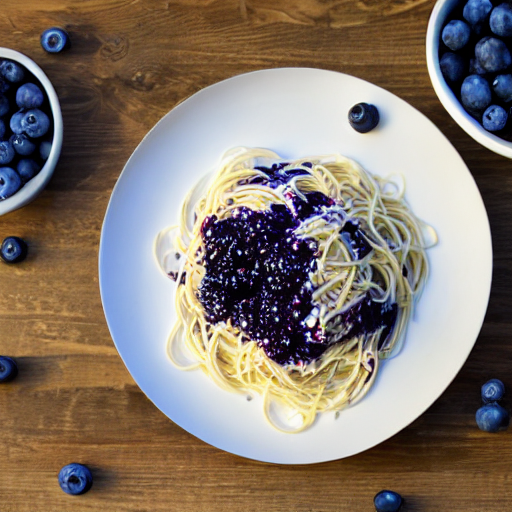

In [ ]:
pipeline('blueberry spaghetti')['sample'][0]

We can provide a noise vector of our own using the `latents` kwarg

  0%|          | 0/51 [00:00<?, ?it/s]

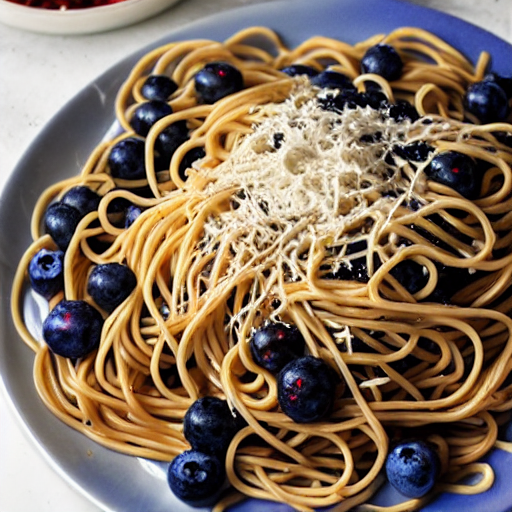

In [ ]:
im = pipeline('blueberry spaghetti', latents=noise_a)['sample'][0]
im

If we run that again with the same noise, we'll get the same image back.

  0%|          | 0/51 [00:00<?, ?it/s]

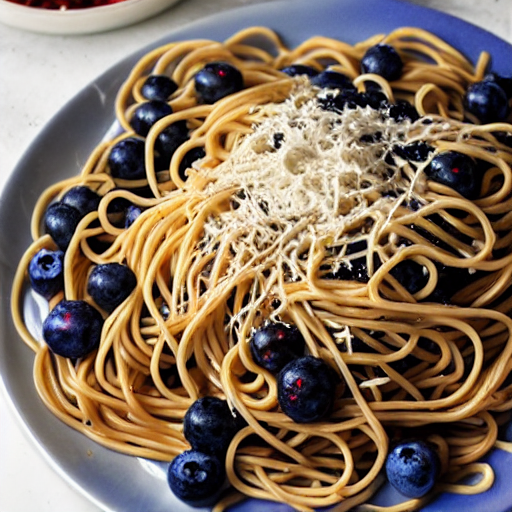

In [ ]:
im = pipeline('blueberry spaghetti', latents=noise_a)['sample'][0]
im

If we change our noise to `noise_b`, we'll get a different image

  0%|          | 0/51 [00:00<?, ?it/s]

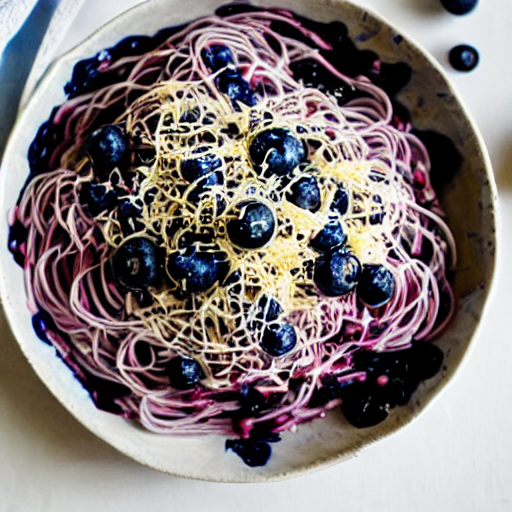

In [ ]:
im = pipeline('blueberry spaghetti', latents=noise_b)['sample'][0]
im

## Interpolating Between Noise Vectors

Now let's interpolate between images A and B as we described earlier...

In [22]:
height = 512
width = 512
noise_shape = (1, 4, height // 8, width // 8)

seed_a = 42
seed_b = 5432

noise_a = torch.randn(
    noise_shape,
    generator=torch.Generator(
        device=pipeline.device
    ).manual_seed(seed_a),
    device=pipeline.device,
)
noise_b = torch.randn(
    noise_shape,
    generator=torch.Generator(
        device=pipeline.device
    ).manual_seed(seed_b),
    device=pipeline.device
)

In [ ]:
# Using same prompt for each image
prompt = 'blueberry spaghetti'

# Steps to interpolate (i.e. number of images to generate)
# If you change the number here, the visualization below will break
num_interpolation_steps = 6

T = torch.linspace(0.0, 1.0, num_interpolation_steps)

images = []
for i, t in enumerate(T):
    print(f"Weight at step {i} - {t:2.2f}")
    noise_t = slerp(float(t), noise_a, noise_b)
    im = pipeline(prompt, latents=noise_t, height=height, width=width)['sample'][0]
    images.append(im)

Let's visualize the frames we just created...

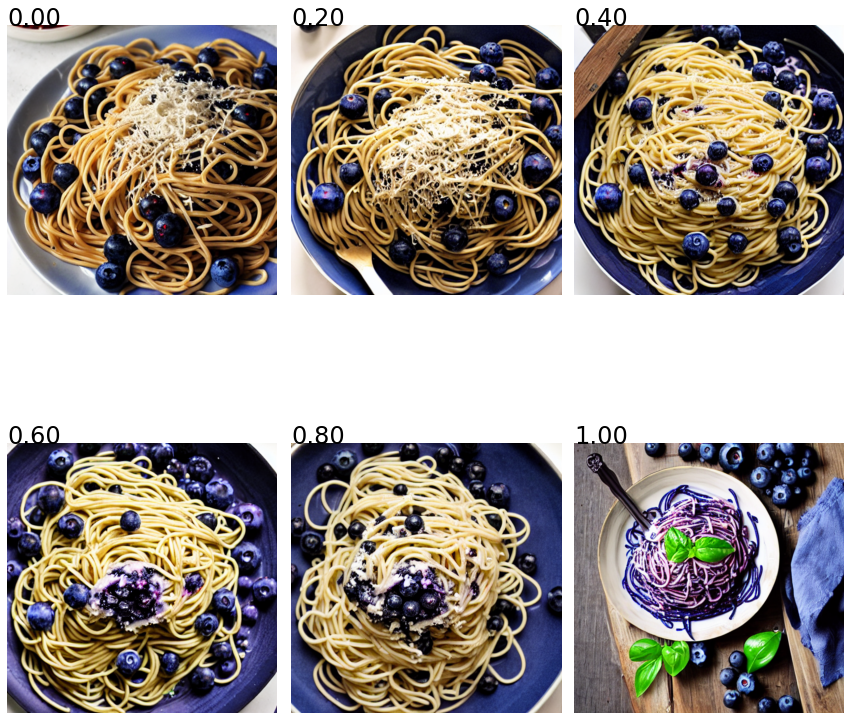

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt

rows, cols = 2, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for r in range(rows):
    for c in range(cols):
        i = (r * cols) + c
        axes[r, c].axis("off")
        axes[r, c].imshow(images[i])
        axes[r, c].text(0, 0, f"{float(T[i]):2.2f}", fontsize=24)

plt.subplots_adjust(wspace=.05, hspace=.05)
plt.grid(False)
plt.show()

Cool! Looks like we got an image in between A and B that seems to makes sense. Let's do more steps and see what that looks like...

This time, we'll save images as we go, and then stitch them back together as a gif with `ffmpeg`.

In [ ]:
from pathlib import Path

output_dir = Path('images')
output_dir.mkdir(exist_ok=True, parents=True)

# Using same prompt for each image
prompt = 'blueberry spaghetti'

# Steps to interpolate (i.e. number of images to generate)
num_interpolation_steps = 10
T = torch.linspace(0.0, 1.0, num_interpolation_steps)

images = []
for i, t in enumerate(T):
    noise_t = slerp(float(t), noise_a, noise_b)
    im = pipeline(prompt, latents=noise_t, height=height, width=width)['sample'][0]
    im.save(output_dir / f'frame{i:06d}.png')

Using ffmpeg, we can bring these together as a clip.

Here, we'll lower the frame rate to 5 frames per second, so we should end up with a 2 second clip containing our 10 generating image frames.


In [ ]:
! ffmpeg -f image2 -framerate 5 -i images/frame%06d.png -loop 0 output_1.gif

It should look like this - pretty cool!

![output_1.gif](https://huggingface.co/datasets/nateraw/documentation-images/resolve/main/output_1.gif)


## Interpolating Noise and Text Embedding Vectors

To ramp it up a notch, lets see if we can interpolate between images with different prompts. To do that, we'll need to modify the `diffusers` `StableDiffusionPipeline` to accept text embeddings, since we'll want to provide intermediate text embeddings.

The main bit we're adding is this snippet, where we allow for a `text_embeddings` kwarg that will override the text `prompt` input.

```python
    if text_embeddings is None:
        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        # get prompt text embeddings
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids

        if text_input_ids.shape[-1] > self.tokenizer.model_max_length:
            removed_text = self.tokenizer.batch_decode(text_input_ids[:, self.tokenizer.model_max_length :])
            print(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer.model_max_length} tokens: {removed_text}"
            )
            text_input_ids = text_input_ids[:, : self.tokenizer.model_max_length]
        text_embeddings = self.text_encoder(text_input_ids.to(self.device))[0]
    else:
        batch_size = text_embeddings.shape[0]
```

Here's the full code for our `StableDiffusionWalkPipeline`:

In [37]:
import inspect
from typing import Optional, Union, List, Callable

from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput

class StableDiffusionWalkPipeline(StableDiffusionPipeline):
    @torch.no_grad()
    def __call__(
        self,
        prompt: Optional[Union[str, List[str]]] = None,
        height: int = 512,
        width: int = 512,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        eta: float = 0.0,
        generator: Optional[torch.Generator] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
        text_embeddings: Optional[torch.FloatTensor] = None,
    ):

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if text_embeddings is None:
            if isinstance(prompt, str):
                batch_size = 1
            elif isinstance(prompt, list):
                batch_size = len(prompt)
            else:
                raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

            # get prompt text embeddings
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids

            if text_input_ids.shape[-1] > self.tokenizer.model_max_length:
                removed_text = self.tokenizer.batch_decode(text_input_ids[:, self.tokenizer.model_max_length :])
                print(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )
                text_input_ids = text_input_ids[:, : self.tokenizer.model_max_length]
            text_embeddings = self.text_encoder(text_input_ids.to(self.device))[0]
        else:
            batch_size = text_embeddings.shape[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            # HACK - Not setting text_input_ids here when walking, so hard coding to max length of tokenizer
            # TODO - Determine if this is OK to do
            # max_length = text_input_ids.shape[-1]
            max_length = self.tokenizer.model_max_length
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # get the initial random noise unless the user supplied it

        # Unlike in other pipelines, latents need to be generated in the target device
        # for 1-to-1 results reproducibility with the CompVis implementation.
        # However this currently doesn't work in `mps`.
        latents_device = "cpu" if self.device.type == "mps" else self.device
        latents_shape = (batch_size, self.unet.in_channels, height // 8, width // 8)
        if latents is None:
            latents = torch.randn(
                latents_shape,
                generator=generator,
                device=latents_device,
                dtype=text_embeddings.dtype,
            )
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")
            latents = latents.to(latents_device)

        # set timesteps
        self.scheduler.set_timesteps(num_inference_steps)

        # Some schedulers like PNDM have timesteps as arrays
        # It's more optimized to move all timesteps to correct device beforehand
        timesteps_tensor = self.scheduler.timesteps.to(self.device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(timesteps_tensor)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if callback is not None and i % callback_steps == 0:
                callback(i, t, latents)

        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        safety_checker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(
            images=image, clip_input=safety_checker_input.pixel_values.to(text_embeddings.dtype)
        )

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

Remove existing pipeline instance before proceeding...

In [38]:
del pipeline
torch.cuda.empty_cache()

Then, initialize the pipeline just as we did before

In [ ]:
pipeline = StableDiffusionWalkPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision='fp16'
).to("cuda")

Great! Now we'll interpolate between text embeddings. We use `torch.lerp` instead of `slerp`, as that's what we've found to be a bit smoother for text.

We'll start by creating two helper functions, `embed_text` and `get_noise` so this repetitive code doesn't muddy up our logic below.

In [40]:
def embed_text(pipeline, text):
    """takes in text and turns it into text embeddings"""
    text_input = pipeline.tokenizer(
        text,
        padding="max_length",
        max_length=pipeline.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        embed = pipeline.text_encoder(text_input.input_ids.to(pipeline.device))[0]
    return embed

def get_noise(pipeline, seed, height=512, width=512):
    """Takes in random seed and returns corresponding noise vector"""
    return torch.randn(
        (1, pipeline.unet.in_channels, height // 8, width // 8),
        generator=torch.Generator(
            device=pipeline.device
        ).manual_seed(seed),
        device=pipeline.device,
    )

In [48]:
# Height and width of image are important for noise vector creation
# Values should be divisible by 8 if less than 512
# Values should be divisible by 64 if greater than 512
height, width = 512, 512

# Prompts/random seeds for A and B
prompt_a, prompt_b = 'blueberry spaghetti', 'strawberry spaghetti'
seed_a, seed_b = 42, 1337

# Noise for A and B
noise_a = get_noise(pipeline, seed_a, height=height, width=width)
noise_b = get_noise(pipeline, seed_b, height=height, width=width)

# Text embeddings for A and B
embed_a = embed_text(pipeline, prompt_a)
embed_b = embed_text(pipeline, prompt_b)

In [ ]:
from pathlib import Path

output_dir = Path('images_walk_with_text')
output_dir.mkdir(exist_ok=True, parents=True)

# Steps to interpolate (i.e. number of images to generate)
num_interpolation_steps = 10
T = torch.linspace(0.0, 1.0, num_interpolation_steps).to(pipeline.device)

images = []
for i, t in enumerate(T):
    noise_t = slerp(float(t), noise_a, noise_b)
    embed_t = torch.lerp(embed_a, embed_b, t)
    im = pipeline(
        text_embeddings=embed_t,
        latents=noise_t,
        height=height,
        width=width
    )['sample'][0]
    im.save(output_dir / f'frame{i:06d}.png')

In [ ]:
! ffmpeg -f image2 -framerate 5 -i images_walk_with_text/frame%06d.png -loop 0 output_2.gif

![output_2.gif](https://huggingface.co/datasets/nateraw/documentation-images/resolve/main/output_2.gif)

## Interpolating to the Beat of a Song

Now we're talking! But how might we now move this video to the beat of a song?

Above, we were moving between images *linearly*. What we want to do is:

  - move more when the energy of a given audio clip is high (it's loud)
  - move less when the energy is low (it's quiet).

We can achieve this by manipulating the weights at certain timesteps that we defined above as `T`. Instead of using `torch.linspace`, we'll try to set these values based on some audio.

Here we define a helper function to visualize numpy arrays. We'll use this to help explain what we're doing.

In [50]:
from matplotlib import pyplot as plt
import numpy as np

def plot_array(y):
    x = np.arange(y.shape[0]) 
    
    # plotting

    plt.title("Line graph") 

    plt.xlabel("X axis") 

    plt.ylabel("Y axis") 

    plt.plot(x, y, color ="red") 
    return plt.show()

Now let's load in an audio clip. The one we're using is the `choice` example clip from `librosa`.

It's a good one because it has drums and bass in it, so it's similar to a song you might want to use (but doesn't involve us using copyrighted music in this notebook 😉).

We'll slice the audio clip so we are only using audio from 0:11-0:14 in the audio.

In [52]:
import librosa
from IPython.display import Audio

n_mels = 512
fps = 12
offset = 11
duration = 3

wav, sr = librosa.load(librosa.example('choice'), offset=offset, duration=duration)
Audio(wav, rate=sr)

Let's take a look at the plot of the waveform:

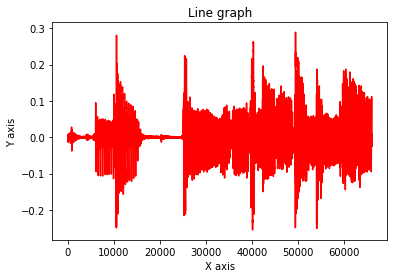

In [68]:
plot_array(wav)

After much experimentation, I found that extracting the percussive elements from the song and using those for everything moving forward leads to the best results.

We'll do this using the `librosa.effects.hpss` function.

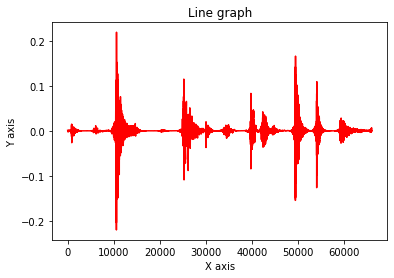

In [69]:
wav_harmonic, wav_percussive = librosa.effects.hpss(wav, margin=(1.0, 5.0))
plot_array(wav_percussive)

As you can see, now the points of percussive impact are more pronounced.

What we'll do next is:

  - Convert that audio to spectrogram
  - Normalize the spectrogram
  - Rescale the spectrogram to be `(duration * fps)` so we have a vector that's the same length as the amount of frames we wish to generate.
  - Plot the resulting array so we can see what it looks like

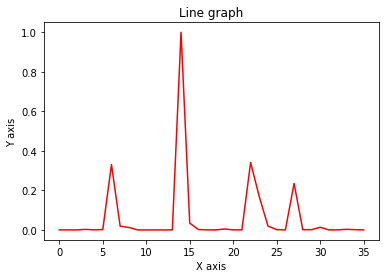

In [70]:
# Number of audio samples per frame
frame_duration = int(sr / fps)

# Generate Mel Spectrogram
spec_raw = librosa.feature.melspectrogram(y=wav_percussive, sr=sr, n_mels=n_mels, hop_length=frame_duration)

# Obtain maximum value per time-frame
spec_max = np.amax(spec_raw, axis=0)

# Normalize all values between 0 and 1
spec_norm = (spec_max - np.min(spec_max)) / np.ptp(spec_max)

# rescale so its exactly the number of frames we want to generate
# 3 seconds at 12 fps == 36
amplitude_arr = np.resize(spec_norm, int(duration * fps))

plot_array(amplitude_arr)

Finally, we'll construct `T`. We could do this in a variety of ways, but the simplest we found was using `np.cumsum` to gather a cumulative sum of the "energy" in the audio array.

Hat tip to [@teddykoker](https://github.com/teddykoker) who helped me figure this out.

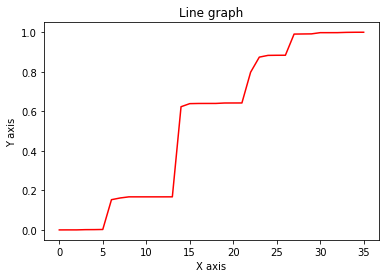

In [71]:
# Cumulative sum of audio energy
T = np.cumsum(amplitude_arr)

# Normalize values of T against last element
T /= T[-1]

# 0th element not always exactly 0.0. Enforcing that here.
T[0] = 0.0

plot_array(T)

Compare the above `T` with our previous definition of `T`...it's a lot different!

We can see the one above is increasing rapidly at points of high energy, while the one below is simply linear.

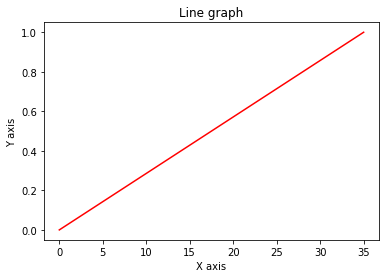

In [72]:
plot_array(np.linspace(0.0, 1.0, fps*duration))

Let's use our newly defined `T` to generate our music video!

📝 **Note** - This cell will take a little while as it has to do the number of steps you see in X-axis above (36 frames)

In [ ]:
from pathlib import Path

output_dir = Path('images_walk_with_audio')
output_dir.mkdir(exist_ok=True, parents=True)

for i, t in enumerate(T):
    noise_t = slerp(float(t), noise_a, noise_b)
    embed_t = torch.lerp(embed_a, embed_b, t)
    im = pipeline(
        text_embeddings=embed_t,
        latents=noise_t,
        height=height,
        width=width
    )['sample'][0]
    im.save(output_dir / f'frame{i:06d}.png')

Let's stitch together the frames we just made as well as the audio clip that goes with it.

First, we'll write that audio clip to a new file, `audio.wav`.

In [59]:
import soundfile as sf

sf.write(output_dir / 'audio.wav', wav, samplerate=sr)

Then, we'll use some `ffmpeg` witchcraft to stitch the frames together into an mp4, including the audio clip we just wrote.

In [ ]:
! ffmpeg \
  -r {fps} \
  -i images_walk_with_audio/frame%06d.png \
  -i images_walk_with_audio/audio.wav \
  -c copy \
  -map 0:v:0 \
  -map 1:a:0 \
  -acodec aac \
  -vcodec libx264 \
  -pix_fmt yuv420p \
  output_walk_with_audio.mp4

Let's take a look at the video we just made. In Colab, you'll have to run some code like this. Otherwise, you can just download the file and open it on your computer.

In [61]:
from IPython.display import HTML
from base64 import b64encode

def visualize_video_colab(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

visualize_video_colab('output_walk_with_audio.mp4')

Success!! 🔥

## Parting Tips

  - The quality of the interpolation is better with higher `fps`. I've been using 30 for most of my serious runs, but 60 is probably even better.
  - The workflow I tend to use is:
    1. Generate images with random seeds, saving them along with the seeds I used.
    2. Pick prompt/seed pairs you like, and use those to generate the videos. That way you know at a high level what the video will look like.
  - You can mess with the `margin` kwarg in `librosa.effects.hpss` to increase/decrease the intensity of the effect we made here.
  - There are TONs of ways to do what we did here, this is just one way. Feel free to experiment with creating your own `T`.
  - The NSFW filter can be too liberal at times when generating videos. I tend to remove it when I'm generating videos for myself, but it's a good idea to keep it in when you're sharing your videos with others. Please do this responsibly.

## Conclusion

Today we saw how to create music videos using Stable Diffusion! If you want a nice interface for doing this, you should check out the [Stable Diffusion Videos repo](https://github.com/nateraw/stable-diffusion-videos), where all of this is wrapped up nicely for you (Check the README for instructions on how to use it for music videos).

If you found this notebook helpful:

  - consider giving this [repo a star](https://github.com/nateraw/stable-diffusion-videos) ⭐️
  - consider following me on Github [@nateraw](https://github.com/nateraw)

Thanks for reading! Cheers 🍻